# Grid Creation and Grid-Based Descriptor Calculation

Another aspect of `molli` is it's ability to create grids, as a lot of the Denmark lab workflows operate with grid-based descriptors.

Note: Pyvista is not natively installed within Molli, but this version can be added through conda using the line:
`pip install pyvista==0.43.10` or `conda install pyvista=0.43.10`

## Grid Creation 

In [1]:
# Import the necessary packages
import molli as ml
import pyvista as pv

#This is currently being run on a virtual server and needs a separate server for display via pyvista
pv.start_xvfb()

In [2]:
# Creates a rectangular grid as a canvas 
g = ml.descriptor.rectangular_grid([-1,-1,0], [1,1,0], spacing=0.5)
print(g.shape)
g

(25, 3)


array([[-1. , -1. ,  0. ],
       [-0.5, -1. ,  0. ],
       [ 0. , -1. ,  0. ],
       [ 0.5, -1. ,  0. ],
       [ 1. , -1. ,  0. ],
       [-1. , -0.5,  0. ],
       [-0.5, -0.5,  0. ],
       [ 0. , -0.5,  0. ],
       [ 0.5, -0.5,  0. ],
       [ 1. , -0.5,  0. ],
       [-1. ,  0. ,  0. ],
       [-0.5,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0.5,  0. ,  0. ],
       [ 1. ,  0. ,  0. ],
       [-1. ,  0.5,  0. ],
       [-0.5,  0.5,  0. ],
       [ 0. ,  0.5,  0. ],
       [ 0.5,  0.5,  0. ],
       [ 1. ,  0.5,  0. ],
       [-1. ,  1. ,  0. ],
       [-0.5,  1. ,  0. ],
       [ 0. ,  1. ,  0. ],
       [ 0.5,  1. ,  0. ],
       [ 1. ,  1. ,  0. ]], dtype=float32)

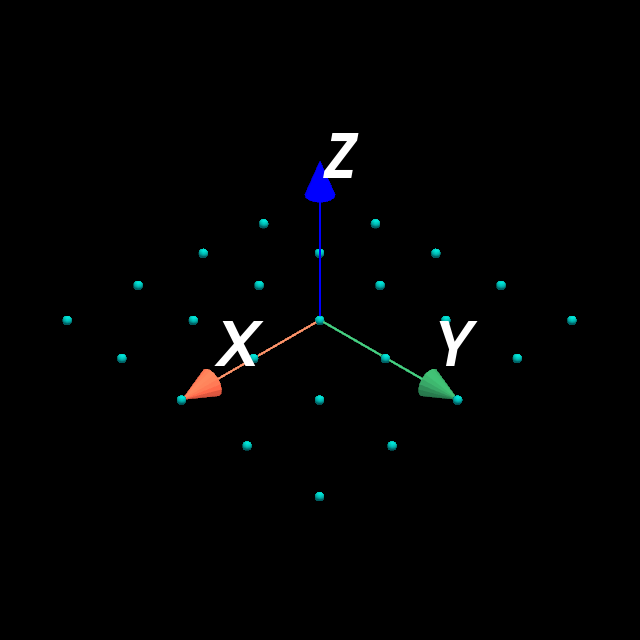

In [3]:
# Adds theme to Pyvista plot and allows for jupyter notebook integration
pv.set_plot_theme("dark") 
plt = pv.Plotter(notebook=True)

# Creates a point cloud from the grid generated by molli and adds it to the plot
points = pv.PointSet(g)

# Adds more features to the plot and displays it
plt.add_mesh(points, color="cyan", render_points_as_spheres=True, point_size=10)
plt.add_axes_at_origin()
plt.show(jupyter_backend="panel", window_size=(640,640))

## Grid-Based Conformer-Average (GBCA) Descriptor Calculation

The command-line interface within `molli` also allows rectangular grid calculation then subsequent descriptor calculation from an existing conformer library file. This can be parallelized, and will be returned as an hdf5 file.

### Grid Calculation
An example command would look like

`molli grid example.clib -o example_grid.hdf5 -s 1.0 -n 16 --prune`

Note: The `--prune` option is necessary for the accelerated GBCA descriptor calculation, but unecessary for standard grid calculation

Other parameters available in the `grid` script are shown below

In [4]:
!molli grid -h

usage: molli grid [-h] [-o <fpath>] [-n NPROCS] [-p 0.0] [-s 1.0]
                  [-b BATCHSIZE] [--prune [<max_dist>:<eps>]]
                  [--nearest [NEAREST]] [--overwrite] [--dtype DTYPE]
                  library

Read a molli library and calculate a grid

positional arguments:
  library               Conformer library file to perform the calculations on

options:
  -h, --help            show this help message and exit
  -o <fpath>, --output <fpath>
                        Destination for calculation results
  -n NPROCS, --nprocs NPROCS
                        Specifies the number of jobs for constructing a grid
  -p 0.0, --padding 0.0
                        The bounding box will be padded by this many angstroms
                        prior to grid construction
  -s 1.0, --spacing 1.0
                        Intervals at which the grid points will be placed
  -b BATCHSIZE, --batchsize BATCHSIZE
                        Number of molecules to be treated simulateneously
  --p

### ASO/AEIF Calculation

The Average Steric Occupancy (ASO) descriptor was originally developed in the Denmark lab to capture the dynamic nature of sterics in a molecule. This measures whether an indiviudal conformer is occupying a grid point or not and assigns it a value of 0 if unoccupied and a value of 1 if occupied. This then averages the amount a grid-point was occupied over the number of conformers calculated, giving a value between 0 and 1. More information can be found at [**DOI**:10.1126/science.aau5631](https://www.science.org/doi/10.1126/science.aau5631)

We have significantly accelerated this descriptor calculation such that it can operate on massive `ConformerLibraries`. This has also been made availble to parallelize for further acceleration. An example of an ASO calculation run through the command line is shown below

`molli gbca aso example.clib -o example_aso.hdf5 -g example_grid.hdf5 -n 16`

The Average Electronic Indicator Field (AEIF) descriptor has a very similar implementation as ASO, with the only difference being the grid-point is not assigned a 0 or 1 for occupancy, rather it is assigned the electronic charge of an atom.

Note: This requires the atomic charges for the `ConformerEnsemble` in each `ConformerLibrary` to be previously calculated and assigned.

Other parameters available in the `gbca` script are shown below

In [5]:
!molli gbca -h

usage: molli gbca [-h] [-w] [-n 128] [-b 128] [-g <grid.hdf5>]
                  [-o <lib_aso.hdf5>] [--dtype DTYPE] [--overwrite]
                  {aso,aeif} CLIB_FILE

This module can be used for standalone computation of descriptors

positional arguments:
  {aso,aeif}            This selects the specific descriptor to compute.
  CLIB_FILE             Conformer library to perform the calculation on

options:
  -h, --help            show this help message and exit
  -w, --weighted        Apply the weights specified in the conformer files
  -n 128, --nprocs 128  Selects number of processors for python
                        multiprocessing application. If the program is
                        launched via MPI backend, this parameter is ignored.
  -b 128, --batchsize 128
                        Number of conformer ensembles to be processed in one
                        batch.
  -g <grid.hdf5>, --grid <grid.hdf5>
                        File that contains the information about the
  